# Topic Modeling
The purpose of this notebook is to compare several algorithms used for topic modeling by clustering a set of documents. The following approaches are compared:
- Non-negative Matrix Factorization - NMF
- Latent Dirichlet Allocation - LDA
- KMeans
- Doc2vec

# Text Representions
Machine learning algorithms are primarily designed to process numerical data. Therefore text has to be converted to some type of numerical representation. There are two approaches to convert text to numbers.

Historically, the first approach to this problem is the vector space model. In the vector space model the collection of all words define the dimensions of the space with one dimension per word. A document is represented as a vector in that space with several options of how to define the actual coordinates of the document in the space: 
- binary - 1 if the word is present in the document, 0 if it isn't
- tf - the number of occurences of the word in the document, often normalized by the number of words in the document
- tfidf - term frequency inverse document frequency

A collection of documents is represented as a document-word matrix, a full cartesian product of all document vectors. Another way to think of this is that a collection of documents is a set of points in an n-dimensional space. Consequently, 'regular' clustering algorithms, such as KMeans or DBSCAN, can be applied. 
Most of the algorithms in this notebook use the vector space model: NMF and KMeans use the tfidf representation and LDA uses the tf represenation.

One problem with this approach is that if a resonable vocabulary - a few tens of thousands of words - is used each document is a sparse vector in a very high-dimensional space. 
It is possible to define the concept of similarity between two documents. However, for individual words such concept cannot be defined. 

The word embedding approach addresses these problems. Each word is represented as a vector in a space with a number of dimensions much smaller than in the vector space model, anywhere from tens to hundreds of dimensions. The coordinates of the vectors, aka word embedding, are computed as part of a process thath uses words to predict words found in their vicinity. There are two basic approaches: the Continuous Bag-of-Words (COW) model and the Skip-Gram model ([original paper](https://arxiv.org/abs/1301.3781)). The benefit of this approach is that the concept of similarity can be applied to the individual words, i.e. words with similary meaning are 'closer' to each other than words with different meaning in the embedded space. 

This approach works well for processing text as a sequence of words, or even characters, in such problems as machine translation, sentence tagging, etc. 
However, it presents a difficulty when there is a need to process a collection of documents. With each word being a vector, a document becomes a matrix - rank2 tensor, and a collection of documents becomes a rank 3 tensor. 
Another complication is that documents in a collection can be of very different sizes. To deal with this problem smaller documents a padded with 0's. This may not be such a problem for small documents, such as tweets, but comparing longer documents with large length variability creates a problem. There are options: to pad all documents to match the longest one, which results  in unnecessary increase in memory use, or to truncate the longer documents, which leads to the loss of information.

Doc2Vec is an extension of word2vec . Doc2vec address both problems, it creates a vector represenation of documents regarless of their sizes, so that a collection of documents is equivalent to a set of points in an n-dimensional space. The details of how this approach works can be found e.g. in [here](https://radimrehurek.com/gensim/models/doc2vec.html) and the references within it. Here we present application of Doc2vec to document clustering. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gc

In [2]:
import warnings; warnings.simplefilter('ignore')

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score
from sklearn.cluster import KMeans

In [4]:
def print_top_words(cluster_centers, feature_names, n_top_words, topic_map):
    for topic_idx, topic in enumerate(cluster_centers):
        message = "Topic# " + topic_map[topic_idx] + " "
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [5]:
def doc2cluster(docs, model):
    clusters = []
    for doc in docs:
        docprob = model.transform(doc)
        cluster = docprob.argmax()
        clusters.append(cluster)
    return clusters

In [6]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from string import punctuation
def clean_text(texts, simple = True, min_length = 2):
    clean = []
    #don't remove apostrophes
    ##table = str.maketrans(' ', ' ', punctuation.replace('\'',' ')) - doesn't replace with ' '
    translator = str.maketrans(punctuation.replace('\'',' '), ' '*len(punctuation))
    for text in texts:
        # split into tokens by white space
        text = text.translate(translator)
        tokens = text.split()
        if not simple:
            # remove not alphabetic tokens
            tokens = [word.lower() for word in tokens if word.isalpha()]
            # filter out stop words
            #stop_words = set(stopwords.words('english'))
            tokens = [w for w in tokens if not w in stop_words]
            # filter out short tokens
            tokens = [word for word in tokens if len(word) >= min_length]
        tokens = ' '.join(tokens)
        clean.append(tokens)
    return clean

In [7]:
USE_CLEAN_DATA = 2

## Read the data from the Sklearn Dataset

In [8]:
%%time
# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))


Wall time: 1.86 s


In [9]:
n_samples = len(dataset.data)
print(n_samples)

if USE_CLEAN_DATA == 2:
    data_samples = clean_text(dataset.data[:n_samples], simple = False)
elif USE_CLEAN_DATA == 1:
    data_samples = clean_text(dataset.data[:n_samples], simple = True)    
else:
    data_samples = dataset.data[:n_samples]

data_labels = dataset.target[:n_samples]
data_label_names = dataset.target_names[:n_samples]


11314


## Set some parameters

In [10]:
n_features = 1000
n_components = 20
n_top_words = 20

## The data is well balanced

In [11]:
np.unique(data_labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([480, 584, 591, 590, 578, 593, 585, 594, 598, 597, 600, 595, 591,
        594, 593, 599, 546, 564, 465, 377], dtype=int64))

## Create two different representation of the document-term dataset
- tf - term frequency, the count of the term in the document
- tfidf (term frequency - inverse document frequency weighting. Tf-idf measures the importance of terms in the documents based on how frequently they occur in the corpus of documents. It gives more weight to terms appearing in fewer documents.

The 'raw' formula for tfidf is 

$tfidf_{i,j} = tf_{i,j} \times idf_i =  tf_{i,j} \times log(\frac{N}{df_i})$

Here $tf_{i,j}$ is the frequency of term $i$ in document $j$, $idf_i$ is the inverse document frequency, $N$ is the number of documents, and $df_i$ is the number of documents in which term $i$ appears.

In practice the raw formula is modified. 1 is added to the defintion of $idf_i$ to avoid the inverse document frequency turning to 0 when the term is present in all documents. 

In addition TfidfVectorizer provides an option of either $l1$ or $l2$ normalization for $tfidf_{i,j}$

tfidf representation is used for  NMF and  Kmeans, LDA uses tf representation

In [12]:
%%time

# Use tf-idf features for NMF.
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(data_samples)

Wall time: 1.29 s


In [13]:
%%time
# Use tf (raw term count) features for LDA.
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')

tf = tf_vectorizer.fit_transform(data_samples)

Wall time: 1.19 s


In [14]:
tfidf_vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=1000, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [15]:
def compute_metrics(true_labels, cluster_labels, parameter, verbose = False):
    h = homogeneity_score(true_labels, cluster_labels)
    c = completeness_score(true_labels, cluster_labels)
    v = v_measure_score(true_labels, cluster_labels)
    r = adjusted_rand_score(true_labels, cluster_labels)
    if verbose == True:
        print (parameter, h,c,v,r)
    return (parameter, h,c,v,r)

The purpose of this exericise is to compare different clustering algorithms. Since we know the correct number of cluster, a number of metrics is available in sklearn to estimate the quality of clustering. 
- Homogeneity score
- Completeness score
- V-measure score
- Adjusted Rand score

These are all external metrics that measure the quality of clustering based on the comparison of the clustering results with the ground truth. This is similar to how supervised classification is evaluated. However, it is more challenging since there is no inherent connection between the groups of points created by clustering and the ground truth classes E.g. with the 20News groups there is a class assigment for each article, it is a number from 0 to 19. The clustering will also assign each article a number from 0 to 19 based on which cluster it is in, but there is only 1 in 20 chance that cluster 0 corresponds to class 0, since those cluster number is assignment is random and has nothing to do with the actuall classes. 

Homogeneity means that each cluster contains only members of a single class. Completeness means that all members of a given class are assigned to the same cluster. Homogeneity score and completeness score measure how close clustering is to achieving homogeneity and completeness; they both are [0-1] bound, with 1 being perfect. It is easy for a clustering algorithm to maximize one or the other of these two metrics if the number of clusters is not fixed: assigning each data sample to it's own cluster yields the homogeneity score = 1, assigning all data points to 1 cluster yields the completeness score = 1. To balance these opposing tendency the V-measure score is defined as the harmonic mean of the homogeneity score and the completeness score. The situation is similar to precision, recall and F-score for classification.

An alternative approach looks at the pair-wise view of all data points. The four measurements true positive $T_P$, false positive $F_P$, true negative $T_N$, and false negative $F_N$ are defined for each pair in a way specific to this problem. If both points belong to the same class and are found in the same cluster $T_P$ is incremented, if both points belong to the same class and are found in differnt clusters $F_N$ is incremented, if the two points belong different classes and are found in the same cluster $F_P$ is incremented, if the two points belong different classes and are found in different clusters $T_N$ is incremented.
Note, that for the supervised classification these quantities are defined differently.
<br> Rand score is defined as simple accuracy:

$Rand = \frac{T_P + T_N}{T_P + T_N + F_P + F_N}$

Rand score is often adjusted or rescaled so that the adjusted score is equal to 0 for a completely random prediction:

$Adjusted Rand = \frac{Rand - E(Rand)}{Max(Rand) - E(Rand}$

where $Max(Rand)$ is the maximim possible Rand score, i.e. the score the perfect matching, and $E(Rand)$ is the expectation value of Rand, which is it's value for random predictions.

These metrics can be used even when the number of clusters is not equal to the number of classes, however, here we only consider this option for the purpose of comparison different clustering algorithms.

In [16]:
results = {}

# NMF - Frobenius Norm Loss

 Non-negative matrix factorization is an approximation of a non-negative matrix as a product of two non-negative matrices. It is a way of performing dimensionality reduction, as long as the two resulting matrices have lower ranks than the original matrix. 
 
Frobenius norm is defined as the square root of the sum of the absolute squares of its elements. The loss is the Frobenius norm of the difference between the original matrix and the approximation by the product of two lower-rank matricies

## Explore l1_ratio

In [18]:
%%time
frob_results = []
for l1_ratio in np.linspace(0.0,1.0, 11):
    nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=l1_ratio).fit(tfidf)
    frob_clusters = doc2cluster(tfidf, nmf)
    frob_results.append(compute_metrics(data_labels, frob_clusters, l1_ratio,verbose = True))

0.0 0.23956913940388505 0.2502046860677658 0.24477143611482527 0.1233116518411545
0.1 0.24463072141589082 0.2565202628043087 0.25043445557732025 0.12561531501927894
0.2 0.22803517220842667 0.24136620389825414 0.23451138694030446 0.12128421751249029
0.30000000000000004 0.24314369622017504 0.2612835364770264 0.25188745056767664 0.11062776573193536
0.4 0.23970779051837013 0.26235476080140635 0.250520497409596 0.09919049321495506
0.5 0.2293977613394348 0.25872839813130427 0.24318186671500064 0.08310295035491214
0.6000000000000001 0.22446939892509826 0.25889582833358743 0.2404566472430771 0.07536106816696043
0.7000000000000001 0.2195505098502711 0.25959411849087183 0.23789902963588613 0.06891359860014029
0.8 0.21468685367799634 0.2616973040289108 0.23587254071764147 0.06144928698552088
0.9 0.20774221387564684 0.2656880994981837 0.2331689899484023 0.05323780936994436
1.0 0.19662993618610206 0.2753781615107728 0.22943500583620546 0.042832928405111804
Wall time: 1min 32s


In [19]:
df_frob = pd.DataFrame.from_records(frob_results, columns = ['l1_ratio', 'Homogeneity','Completeness',
                                                       'V_Measure', 'Adjusted_Rand_Index'])

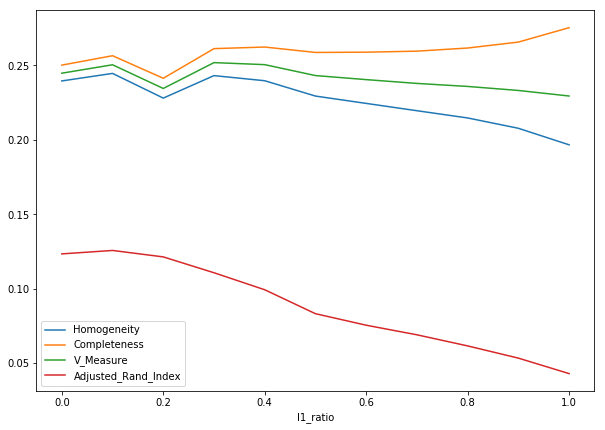

In [20]:
plt.figure(figsize=(10,7))
plt.plot(df_frob.l1_ratio, df_frob.Homogeneity)
plt.plot(df_frob.l1_ratio, df_frob.Completeness)
plt.plot(df_frob.l1_ratio, df_frob.V_Measure)
plt.plot(df_frob.l1_ratio, df_frob.Adjusted_Rand_Index)
plt.xlabel('l1_ratio')
plt.legend()
plt.show()

In [95]:
optimal_l1_ratio = 0.1

## Explore alpha

In [96]:
%%time
frob_results = []
parameter_name = 'alpha'
for alpha in np.linspace(0.02,0.2,10):
    parameter = alpha
    nmf = NMF(n_components=n_components, random_state=1,
          alpha=alpha, l1_ratio=optimal_l1_ratio).fit(tfidf)
    frob_clusters = doc2cluster(tfidf, nmf)
    frob_results.append(compute_metrics(data_labels, frob_clusters, parameter))

Wall time: 1min 32s


In [97]:
df_frob = pd.DataFrame.from_records(frob_results, columns = [parameter_name, 'Homogeneity','Completeness',
                                                       'V_Measure', 'Adjusted_Rand_Index'])

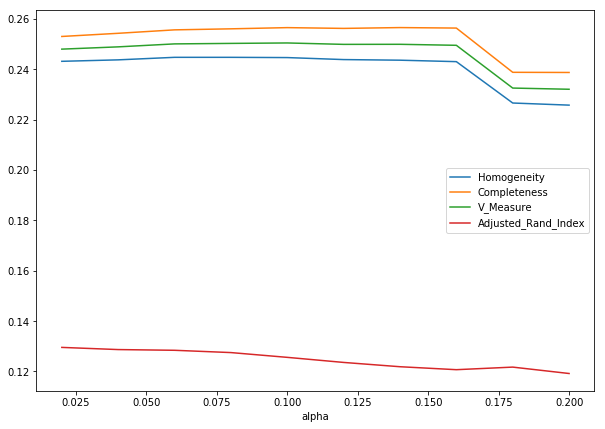

In [98]:
plt.figure(figsize=(10,7))
plt.plot(df_frob[parameter_name], df_frob.Homogeneity)
plt.plot(df_frob[parameter_name], df_frob.Completeness)
plt.plot(df_frob[parameter_name], df_frob.V_Measure)
plt.plot(df_frob[parameter_name], df_frob.Adjusted_Rand_Index)
plt.xlabel(parameter_name)
plt.legend()
plt.show()

In [99]:
optimal_alpha = 0.05

In [100]:
%%time
nmf = NMF(n_components=n_components, random_state=1,  alpha=optimal_alpha, l1_ratio=optimal_l1_ratio).fit(tfidf)
frob_clusters = doc2cluster(tfidf, nmf)

Wall time: 9.75 s


## Map Clusters to News Group
Each cluster is mapped to the News Groups with which it has the greatest overlap. 
<br>Mapping is only suggestive.
<br>Not all News Groups get selected.

In [101]:
newsgroup_map = {}
for i in range(n_components):
    out = np.unique(np.array(data_labels)[np.array(frob_clusters ) == i], return_counts=True)
    index = np.argmax(out[1])
    newsgroup_map[i] = data_label_names[out[0][index]]

In [102]:
newsgroup_map

{0: 'rec.motorcycles',
 1: 'comp.windows.x',
 2: 'rec.sport.hockey',
 3: 'soc.religion.christian',
 4: 'comp.graphics',
 5: 'comp.sys.ibm.pc.hardware',
 6: 'sci.med',
 7: 'sci.crypt',
 8: 'rec.autos',
 9: 'sci.med',
 10: 'comp.sys.ibm.pc.hardware',
 11: 'rec.motorcycles',
 12: 'alt.atheism',
 13: 'comp.os.ms-windows.misc',
 14: 'misc.forsale',
 15: 'comp.sys.mac.hardware',
 16: 'talk.politics.guns',
 17: 'sci.electronics',
 18: 'sci.space',
 19: 'talk.politics.mideast'}

In [103]:
np.unique(np.array(data_labels)[np.array(frob_clusters ) == 0], return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([ 93,  64,  48,  46,  59,  18,  24, 118, 234, 137,  77,  49, 128,
        160,  89,  58,  74,  81,  76,  77], dtype=int64))

In [104]:
homogeneity = homogeneity_score(data_labels, frob_clusters)
completeness = completeness_score(data_labels, frob_clusters)
v_measure = v_measure_score(data_labels, frob_clusters)
adjusted_rand = adjusted_rand_score(data_labels, frob_clusters)

In [105]:
print(homogeneity)
print(completeness)
print(v_measure)
print(adjusted_rand)

0.24432925917787332
0.2550342390639494
0.24956700645873767
0.12880346798744277


In [106]:
results['NMF Frobenius Norm'] = [homogeneity, completeness, v_measure, adjusted_rand ]

### Topics in NMF Frobenius Norm model 

In [107]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf.components_, tfidf_feature_names, n_top_words, newsgroup_map)

Topic# rec.motorcycles good time really got going better bike sure way thing long right years little say make want probably course point
Topic# comp.windows.x window display server application manager using motif program code screen widget set running color user sun size way mit right
Topic# rec.sport.hockey game team year games season players play hockey win league teams player nhl baseball runs best toronto hit played division
Topic# soc.religion.christian god jesus bible believe christ faith christian christians church life say sin truth hell lord man christianity belief true love
Topic# comp.graphics thanks mail advance looking hi info help information address email post appreciated anybody send appreciate interested reply wondering need tell
Topic# comp.sys.ibm.pc.hardware drive scsi hard drives disk ide floppy controller cd mac internal tape power rom cable mb computer software switch dos
Topic# sci.med edu soon university cs email ftp article internet pub david send mail mit apr

# NMF - Kullback-Leibler Loss

Kullback-Leibler, also known as relative entropy, is used when observed data is replaced with an approximation. Kullback-Leibler divergence loss is a measure how much information is lost when the approximation is used

In [34]:
%%time
nmf_kl = NMF(n_components=n_components, random_state=1, beta_loss='kullback-leibler', solver='mu', max_iter=1000, ).fit(tfidf)
kl_clusters = doc2cluster(tfidf, nmf_kl)

Wall time: 3min 23s


In [35]:
homogeneity = homogeneity_score(data_labels, kl_clusters)
completeness = completeness_score(data_labels, kl_clusters)
v_measure = v_measure_score(data_labels, kl_clusters)
adjusted_rand = adjusted_rand_score(data_labels, kl_clusters)

In [36]:
print(homogeneity)
print(completeness)
print(v_measure)
print(adjusted_rand)

0.1975050935912603
0.20070248805948673
0.19909095413936284
0.10912081843093292


In [37]:
results['NMF Kullback-Leibler'] = [homogeneity, completeness, v_measure, adjusted_rand ]

In [38]:
newsgroup_map = {}
for i in range(n_components):
    out = np.unique(np.array(data_labels)[np.array(kl_clusters ) == i], return_counts=True)
    index = np.argmax(out[1])
    newsgroup_map[i] = data_label_names[out[0][index]]

In [39]:
newsgroup_map

{0: 'soc.religion.christian',
 1: 'comp.os.ms-windows.misc',
 2: 'rec.sport.hockey',
 3: 'comp.graphics',
 4: 'talk.politics.mideast',
 5: 'misc.forsale',
 6: 'comp.windows.x',
 7: 'sci.crypt',
 8: 'rec.autos',
 9: 'sci.med',
 10: 'comp.sys.ibm.pc.hardware',
 11: 'rec.sport.baseball',
 12: 'sci.med',
 13: 'talk.politics.guns',
 14: 'sci.med',
 15: 'rec.autos',
 16: 'comp.windows.x',
 17: 'sci.electronics',
 18: 'sci.space',
 19: 'comp.windows.x'}

### Topics in NMF Kullback-Leibler model 

In [40]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf_kl.components_, tfidf_feature_names, n_top_words, newsgroup_map)

Topic# soc.religion.christian say point fact time believe way case make course people really true said life god things matter times mind non
Topic# comp.os.ms-windows.misc windows using program software file help need run thanks files running use ftp dos version work pc problem hi tried
Topic# rec.sport.hockey year game team got games play season win years players second teams league red great time player hit hockey watch
Topic# comp.graphics thanks mail looking know hi advance post send info email help information reply anybody tell god address wondering interested appreciated
Topic# talk.politics.mideast state war national government research israel mr states subject years public clinton american washington press israeli organization information weapons political
Topic# misc.forsale drive sale price hard offer sell new condition used interested shipping scsi model asking power mac old computer original buy
Topic# comp.windows.x edu university following soon john david hope free inclu

# LDA

Latent Dirichlet Allocation is a generative statistical model used in NLP for topic discovery. The basic assumptions of LDA are
- each topic is a distribution over words
- each document is a mixture of corpus-wide topics
- each word is drawn from one of these topics
- only the words within the documents are observed, while the topics are hidden variables (hence the name latent0

In [41]:
help(LatentDirichletAllocation)

Help on class LatentDirichletAllocation in module sklearn.decomposition.online_lda:

class LatentDirichletAllocation(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  Latent Dirichlet Allocation with online variational Bayes algorithm
 |  
 |  .. versionadded:: 0.17
 |  
 |  Read more in the :ref:`User Guide <LatentDirichletAllocation>`.
 |  
 |  Parameters
 |  ----------
 |  n_components : int, optional (default=10)
 |      Number of topics.
 |  
 |  doc_topic_prior : float, optional (default=None)
 |      Prior of document topic distribution `theta`. If the value is None,
 |      defaults to `1 / n_components`.
 |      In [1]_, this is called `alpha`.
 |  
 |  topic_word_prior : float, optional (default=None)
 |      Prior of topic word distribution `beta`. If the value is None, defaults
 |      to `1 / n_components`.
 |      In [1]_, this is called `eta`.
 |  
 |  learning_method : 'batch' | 'online', default='batch'
 |      Method used to update `_component`. Only used

### Online learning method

In [42]:
%%time
lda = LatentDirichletAllocation(n_components=n_components, max_iter=20,
                                learning_method='online', learning_offset=50., random_state=0)
lda.fit(tf)

Wall time: 56.9 s


In [43]:
%%time
lda_clusters = doc2cluster(tf, lda)
homogeneity = homogeneity_score(data_labels, lda_clusters)
completeness = completeness_score(data_labels, lda_clusters)
v_measure = v_measure_score(data_labels, lda_clusters)
adjusted_rand = adjusted_rand_score(data_labels, lda_clusters)
print(homogeneity)
print(completeness)
print(v_measure)
print(adjusted_rand)

0.23598883454843383
0.2610750293052632
0.24789889740840806
0.12662640017839202
Wall time: 6.35 s


### Batch learning method

In [44]:
%%time
lda = LatentDirichletAllocation(n_components=n_components, max_iter=20,
                                learning_method='batch', learning_offset=50., random_state=0)
lda.fit(tf)

Wall time: 1min 7s


In [45]:
lda_clusters = doc2cluster(tf, lda)
homogeneity = homogeneity_score(data_labels, lda_clusters)
completeness = completeness_score(data_labels, lda_clusters)
v_measure = v_measure_score(data_labels, lda_clusters)
adjusted_rand = adjusted_rand_score(data_labels, lda_clusters)
print(homogeneity)
print(completeness)
print(v_measure)
print(adjusted_rand)

0.2645943241777596
0.28553419969750404
0.2746657383492769
0.1324080144633329


## Explore doc_topic_prior

In [46]:
%%time
lda_results = []
parameter_name = 'doc_topic_prior '
for doc_topic_prior  in [0.001, 0.003, 0.008, 0.01, 0.02, 0.05]:
    parameter = doc_topic_prior
    lda = LatentDirichletAllocation(n_components=n_components, max_iter=20, doc_topic_prior = doc_topic_prior,
                                learning_method='batch', learning_offset=50., random_state=0)
    lda.fit(tf)
    lda_clusters = doc2cluster(tf, lda)
    lda_results.append(compute_metrics(data_labels, lda_clusters, parameter))

Wall time: 7min 20s


In [47]:
df_lda = pd.DataFrame.from_records(lda_results, columns = [parameter_name, 'Homogeneity','Completeness',
                                                       'V_Measure', 'Adjusted_Rand_Index'])

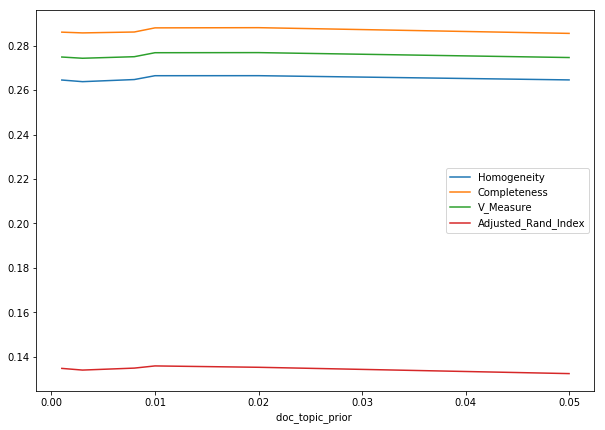

In [48]:
plt.figure(figsize=(10,7))
plt.plot(df_lda[parameter_name], df_lda.Homogeneity)
plt.plot(df_lda[parameter_name], df_lda.Completeness)
plt.plot(df_lda[parameter_name], df_lda.V_Measure)
plt.plot(df_lda[parameter_name], df_lda.Adjusted_Rand_Index)
plt.xlabel(parameter_name)
plt.legend()
plt.show()

In [108]:
optimal_doc_topic_prior = 0.01

## Explore topic_word_prior

In [109]:
%%time
lda_results = []
parameter_name = 'topic_word_prior '
for topic_word_prior  in [0.001, 0.003, 0.008, 0.01, 0.02, 0.05]:
    parameter = topic_word_prior
    lda = LatentDirichletAllocation(n_components=n_components, max_iter=20, doc_topic_prior = optimal_doc_topic_prior,
                        topic_word_prior = topic_word_prior, learning_method='batch', learning_offset=50., random_state=0)
    lda.fit(tf)
    lda_clusters = doc2cluster(tf, lda)
    lda_results.append(compute_metrics(data_labels, lda_clusters, parameter))

Wall time: 7min 11s


In [110]:
df_lda = pd.DataFrame.from_records(lda_results, columns = [parameter_name, 'Homogeneity','Completeness',
                                                       'V_Measure', 'Adjusted_Rand_Index'])

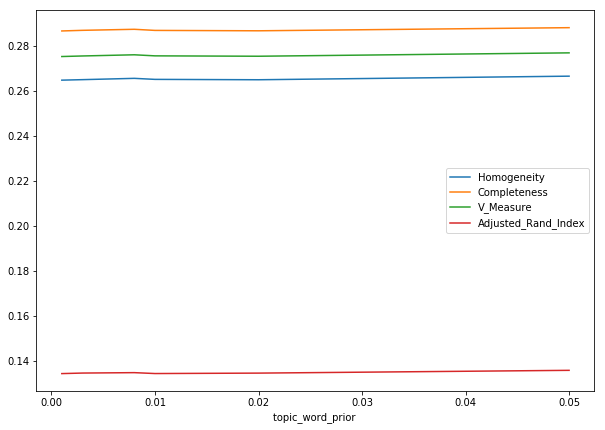

In [111]:
plt.figure(figsize=(10,7))
plt.plot(df_lda[parameter_name], df_lda.Homogeneity)
plt.plot(df_lda[parameter_name], df_lda.Completeness)
plt.plot(df_lda[parameter_name], df_lda.V_Measure)
plt.plot(df_lda[parameter_name], df_lda.Adjusted_Rand_Index)
plt.xlabel(parameter_name)
plt.legend()
plt.show()

In [112]:
optimal_topic_word_prior = 0.01

### Run with the optimal parameters

In [113]:
%%time
lda = LatentDirichletAllocation(n_components=n_components, max_iter=20,doc_topic_prior = optimal_doc_topic_prior,
             topic_word_prior = optimal_topic_word_prior,  learning_method='batch', learning_offset=50., random_state=0)
lda.fit(tf)

Wall time: 1min 6s


In [114]:
lda_clusters = doc2cluster(tf, lda)
homogeneity = homogeneity_score(data_labels, lda_clusters)
completeness = completeness_score(data_labels, lda_clusters)
v_measure = v_measure_score(data_labels, lda_clusters)
adjusted_rand = adjusted_rand_score(data_labels, lda_clusters)
print(homogeneity)
print(completeness)
print(v_measure)
print(adjusted_rand)

0.2650585411848684
0.28680168606002965
0.2755017765855307
0.1344352215377985


In [115]:
results['LDA'] = [homogeneity, completeness, v_measure, adjusted_rand ]

In [116]:
newsgroup_map = {}
for i in range(n_components):
    out = np.unique(np.array(data_labels)[np.array(lda_clusters ) == i], return_counts=True)
    index = np.argmax(out[1])
    newsgroup_map[i] = data_label_names[out[0][index]]

In [117]:
newsgroup_map

{0: 'comp.os.ms-windows.misc',
 1: 'sci.space',
 2: 'soc.religion.christian',
 3: 'comp.sys.ibm.pc.hardware',
 4: 'rec.sport.hockey',
 5: 'comp.os.ms-windows.misc',
 6: 'talk.politics.guns',
 7: 'rec.autos',
 8: 'rec.sport.baseball',
 9: 'comp.windows.x',
 10: 'comp.graphics',
 11: 'misc.forsale',
 12: 'sci.crypt',
 13: 'rec.motorcycles',
 14: 'comp.windows.x',
 15: 'misc.forsale',
 16: 'talk.politics.mideast',
 17: 'sci.electronics',
 18: 'sci.med',
 19: 'talk.politics.mideast'}

### Topics in LDA model 

In [118]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda.components_, tf_feature_names, n_top_words, newsgroup_map)

Topic# comp.os.ms-windows.misc max pl cx bhj giz wm ah chz bxn sl gk lk bj mq qq ax hz sc tm mr
Topic# sci.space space nasa launch earth data satellite scx orbit shuttle station moon dc surface new commercial program development cost technology gov
Topic# soc.religion.christian god jesus people believe bible christian say church life think true faith christians religion christ way truth time world man
Topic# comp.sys.ibm.pc.hardware windows card dos scsi pc mac memory use video bit problem software thanks know bus using monitor ram driver drivers
Topic# rec.sport.hockey new vs la hockey san period team st pts league gm chicago pittsburgh nhl van city play york los toronto
Topic# comp.os.ms-windows.misc file output program entry files section line build check int code ok info win input use rules read title define
Topic# talk.politics.guns people gun think right law government make state like case guns rights control person crime point say use laws evidence
Topic# rec.autos car new price

# KMeans

In [60]:
%%time
kmeans = KMeans(n_clusters=n_components, random_state=0).fit(tfidf)

Wall time: 1min 30s


In [61]:
homogeneity = homogeneity_score(data_labels, kmeans.labels_)
completeness = completeness_score(data_labels, kmeans.labels_)
v_measure = v_measure_score(data_labels, kmeans.labels_)
adjusted_rand = adjusted_rand_score(data_labels, kmeans.labels_)

In [62]:
print(homogeneity)
print(completeness)
print(v_measure)
print(adjusted_rand)

0.2199985070682289
0.2604745649520214
0.23853164206578453
0.05857306816018601


In [63]:
results['KMeans'] = [homogeneity, completeness, v_measure, adjusted_rand ]

In [64]:
newsgroup_map = {}
for i in range(n_components):
    out = np.unique(np.array(data_labels)[np.array(kmeans.labels_ ) == i], return_counts=True)
    index = np.argmax(out[1])
    newsgroup_map[i] = data_label_names[out[0][index]]

In [65]:
newsgroup_map

{0: 'talk.politics.guns',
 1: 'talk.politics.mideast',
 2: 'sci.med',
 3: 'sci.med',
 4: 'rec.autos',
 5: 'comp.windows.x',
 6: 'comp.graphics',
 7: 'comp.sys.ibm.pc.hardware',
 8: 'comp.windows.x',
 9: 'comp.sys.ibm.pc.hardware',
 10: 'sci.electronics',
 11: 'sci.crypt',
 12: 'sci.electronics',
 13: 'soc.religion.christian',
 14: 'comp.os.ms-windows.misc',
 15: 'rec.sport.hockey',
 16: 'sci.space',
 17: 'talk.politics.guns',
 18: 'misc.forsale',
 19: 'soc.religion.christian'}

### Topics in KMeans model 

In [66]:
tf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(kmeans.cluster_centers_, tfidf_feature_names, n_top_words, newsgroup_map)

Topic# talk.politics.guns com email dave internet phone list hp ibm thanks sun like mail used article jim want reply address know paul
Topic# talk.politics.mideast people israel government israeli armenian jews armenians think right said turkish war like state know arab world time rights killed
Topic# sci.med think know time really say right evidence said years way believe case make course question long new point people law
Topic# sci.med edu soon university cs mail email know pub ftp internet thanks send mit david article like need good reply info
Topic# rec.autos car bike cars engine like miles good new speed know think right time used make fast really buy want way
Topic# comp.windows.x window manager application use display using windows server like program problem widget code running set motif title user way size
Topic# comp.graphics thanks advance mail know hi help looking info information appreciated anybody email need software address post use appreciate send program
Topic# comp

# Doc2Vec

In [67]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [68]:
textLabeled = []
for textID, text in enumerate(data_samples):
    textL = TaggedDocument(words=text.split(), tags = ['text_%s' %textID])
    textLabeled.append(textL)


In [69]:
doc2vec_model = Doc2Vec(vector_size=32, window=10, dbow_words = 1, min_count=2,  alpha=0.025,  min_alpha=0.025)
doc2vec_model.build_vocab(textLabeled)

In [70]:
help(Doc2Vec)

Help on class Doc2Vec in module gensim.models.doc2vec:

class Doc2Vec(gensim.models.base_any2vec.BaseWordEmbeddingsModel)
 |  Class for training, using and evaluating neural networks described in
 |  `Distributed Representations of Sentences and Documents <http://arxiv.org/abs/1405.4053v2>`_.
 |  
 |  Some important internal attributes are the following:
 |  
 |  Attributes
 |  ----------
 |  wv : :class:`~gensim.models.keyedvectors.Word2VecKeyedVectors`
 |      This object essentially contains the mapping between words and embeddings. After training, it can be used
 |      directly to query those embeddings in various ways. See the module level docstring for examples.
 |  
 |  docvecs : :class:`~gensim.models.keyedvectors.Doc2VecKeyedVectors`
 |      This object contains the paragraph vectors. Remember that the only difference between this model and
 |      :class:`~gensim.models.word2vec.Word2Vec` is that besides the word vectors we also include paragraph embeddings
 |      to captur

In [71]:
%%time
for epoch in range(100):
    doc2vec_model.train(textLabeled, total_examples=doc2vec_model.corpus_count, epochs=1)
    doc2vec_model.alpha -= 0.0001  # decrease the learning rate
    doc2vec_model.min_alpha = doc2vec_model.alpha  # fix the learning rate, no decay

print ('doc2vec shape: ',doc2vec_model.docvecs.vectors_docs.shape)

doc2vec shape:  (11314, 32)
Wall time: 1min 52s


In [72]:
textVect = doc2vec_model.docvecs.vectors_docs

In [73]:
kmd2v = KMeans(n_clusters=n_components, max_iter=1000)
kmd2v.fit(textVect)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [74]:
print(homogeneity_score(data_labels, kmd2v.labels_))
print(completeness_score(data_labels, kmd2v.labels_))
print(v_measure_score(data_labels, kmd2v.labels_))
print(adjusted_rand_score(data_labels, kmd2v.labels_))

0.30481812421363685
0.3427858743327324
0.32268901197512756
0.1115551609548136


## Explore embed dim

In [75]:
%%time
d2v_results = []
parameter_name = 'embed_dim'
for embed_dim in [16, 32, 48, 64]:
    parameter = embed_dim
    doc2vec_model = Doc2Vec(vector_size=embed_dim, window=10, dbow_words = 1, min_count=2,  alpha=0.025,  min_alpha=0.025)
    doc2vec_model.build_vocab(textLabeled)
    for epoch in range(100):
        doc2vec_model.train(textLabeled, total_examples=doc2vec_model.corpus_count, epochs=1)
        doc2vec_model.alpha -= 0.0001  # decrease the learning rate
        doc2vec_model.min_alpha = doc2vec_model.alpha  # fix the learning rate, no decay
    textVect = doc2vec_model.docvecs.vectors_docs
    kmd2v = KMeans(n_clusters=n_components, max_iter=1000)
    kmd2v.fit(textVect)
    d2v_results.append(compute_metrics(data_labels, kmd2v.labels_, parameter))


Wall time: 7min 54s


In [76]:
df_d2v = pd.DataFrame.from_records(d2v_results, columns = [parameter_name, 'Homogeneity','Completeness',
                                                       'V_Measure', 'Adjusted_Rand_Index'])

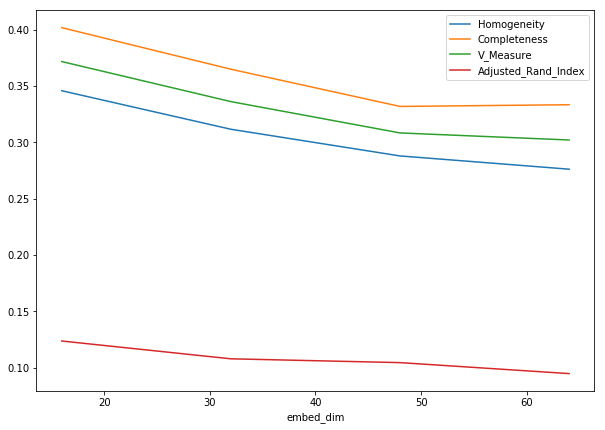

In [77]:
plt.figure(figsize=(10,7))
plt.plot(df_d2v[parameter_name], df_d2v.Homogeneity)
plt.plot(df_d2v[parameter_name], df_d2v.Completeness)
plt.plot(df_d2v[parameter_name], df_d2v.V_Measure)
plt.plot(df_d2v[parameter_name], df_d2v.Adjusted_Rand_Index)
plt.xlabel(parameter_name)
plt.legend()
plt.show()

In [119]:
optimal_vector_size = 16

## Explore window

In [120]:
%%time
d2v_results = []
parameter_name = 'window'
for window in [2,4,6,8,10]:
    parameter = window
    doc2vec_model = Doc2Vec(vector_size=optimal_vector_size, window=window, dbow_words = 1, min_count=2, 
                            alpha=0.025,  min_alpha=0.025)
    doc2vec_model.build_vocab(textLabeled)
    for epoch in range(100):
        doc2vec_model.train(textLabeled, total_examples=doc2vec_model.corpus_count, epochs=1)
        doc2vec_model.alpha -= 0.0001  # decrease the learning rate
        doc2vec_model.min_alpha = doc2vec_model.alpha  # fix the learning rate, no decay
    textVect = doc2vec_model.docvecs.vectors_docs
    kmd2v = KMeans(n_clusters=n_components, max_iter=1000)
    kmd2v.fit(textVect)
    d2v_results.append(compute_metrics(data_labels, kmd2v.labels_, parameter))


Wall time: 8min 51s


In [121]:
df_d2v = pd.DataFrame.from_records(d2v_results, columns = [parameter_name, 'Homogeneity','Completeness',
                                                       'V_Measure', 'Adjusted_Rand_Index'])

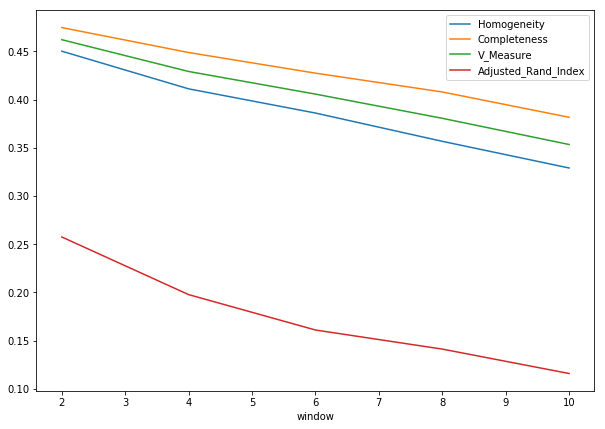

In [122]:
plt.figure(figsize=(10,7))
plt.plot(df_d2v[parameter_name], df_d2v.Homogeneity)
plt.plot(df_d2v[parameter_name], df_d2v.Completeness)
plt.plot(df_d2v[parameter_name], df_d2v.V_Measure)
plt.plot(df_d2v[parameter_name], df_d2v.Adjusted_Rand_Index)
plt.xlabel(parameter_name)
plt.legend()
plt.show()

In [123]:
optimal_window = 2

In [124]:
%%time
doc2vec_model = Doc2Vec(vector_size=optimal_vector_size, window=optimal_window, dbow_words = 1, 
                        min_count=2,  alpha=0.025,  min_alpha=0.025)
doc2vec_model.build_vocab(textLabeled)
for epoch in range(100):
    doc2vec_model.train(textLabeled, total_examples=doc2vec_model.corpus_count, epochs=1)
    doc2vec_model.alpha -= 0.0001  # decrease the learning rate
    doc2vec_model.min_alpha = doc2vec_model.alpha  # fix the learning rate, no decay
textVect = doc2vec_model.docvecs.vectors_docs
kmd2v = KMeans(n_clusters=n_components, max_iter=1000)
kmd2v.fit(textVect)


Wall time: 1min 43s


In [125]:
homogeneity = homogeneity_score(data_labels, kmd2v.labels_)
completeness = completeness_score(data_labels, kmd2v.labels_)
v_measure = v_measure_score(data_labels, kmd2v.labels_)
adjusted_rand = adjusted_rand_score(data_labels, kmd2v.labels_)

In [126]:
print(homogeneity)
print(completeness)
print(v_measure)
print(adjusted_rand)

0.4455271888433004
0.4670297038446718
0.45602511520644884
0.26228278724826587


In [127]:
results['Doc2vec'] = [homogeneity, completeness, v_measure, adjusted_rand ]

In [128]:
newsgroup_map = {}
for i in range(n_components):
    out = np.unique(np.array(data_labels)[np.array(kmd2v.labels_ ) == i], return_counts=True)
    index = np.argmax(out[1])
    newsgroup_map[i] = data_label_names[out[0][index]]

In [129]:
newsgroup_map

{0: 'sci.space',
 1: 'comp.graphics',
 2: 'comp.windows.x',
 3: 'talk.politics.mideast',
 4: 'sci.crypt',
 5: 'rec.autos',
 6: 'comp.sys.mac.hardware',
 7: 'alt.atheism',
 8: 'talk.politics.guns',
 9: 'rec.sport.hockey',
 10: 'soc.religion.christian',
 11: 'rec.sport.hockey',
 12: 'rec.autos',
 13: 'rec.sport.baseball',
 14: 'comp.os.ms-windows.misc',
 15: 'comp.os.ms-windows.misc',
 16: 'misc.forsale',
 17: 'talk.politics.misc',
 18: 'rec.sport.baseball',
 19: 'sci.med'}

### Topics in Doc2vec model 

In [130]:
from collections import Counter
for i in range(n_components):
    topic_docs = np.array(data_samples)[np.array(kmd2v.labels_ ) == i]
    words = []
    for doc in topic_docs:
        words.extend(doc.split())
    count = Counter(words)
    common_words = [x[0] for x in count.most_common()[:n_top_words]]
    print('Topic# ', newsgroup_map[i], ' '.join(common_words) )

Topic#  sci.space space would one nasa also launch program time think us president know get first new satellite system orbit earth like
Topic#  comp.graphics edu image graphics com use would ftp available also data software files windows file mail version like program one jpeg
Topic#  comp.windows.x file window program use output get entry edu widget one server motif using set available also display com line application
Topic#  talk.politics.mideast people one armenian would said armenians turkish israel jews us know war israeli like time even could first two say
Topic#  sci.crypt key db encryption would one use chip clipper system government keys privacy security public people information law like data get
Topic#  rec.autos one car would like get bike good use much well time know also used new back may think cars two
Topic#  comp.sys.mac.hardware scsi one drive card use would bit like mac get know system also drives disk data hard need speed bus
Topic#  alt.atheism people one would th

# Compare All Results

In [131]:
index = ['homogeneity', 'completeness', 'v_measure', 'adjusted_rand' ]

In [136]:
df_results = pd.DataFrame(results, index = index)

In [137]:
df_results

,NMF Frobenius Norm,NMF Kullback-Leibler,LDA,KMeans,Doc2vec
homogeneity,0.244329,0.197505,0.265059,0.219999,0.445527
completeness,0.255034,0.200702,0.286802,0.260475,0.467030
v_measure,0.249567,0.199091,0.275502,0.238532,0.456025
adjusted_rand,0.128803,0.109121,0.134435,0.058573,0.262283


In [138]:
#df_results.to_csv('data/20 News Topic modeling results.csv')

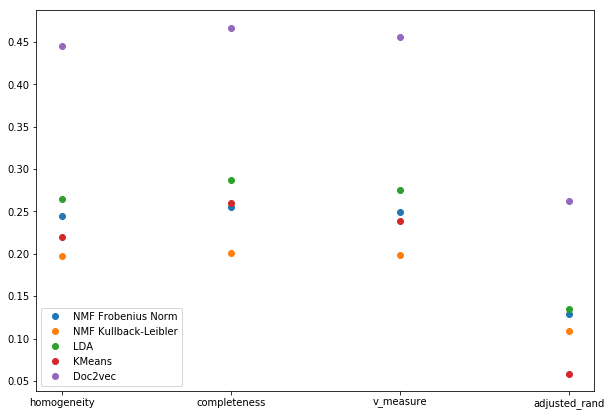

In [139]:
plt.figure(figsize=(10,7))
for col in df_results:
    plt.plot(index, df_results[col], 'o')

plt.legend()
plt.show()

# Doc2vec is clearly the winner